In [17]:
# ! pip install sankeyflow pandas numpy matplotlib rasterio dotenv

# ! pip freeze > ../requirements.txt

In [18]:
import os
import pandas as pd
from sankeyflow import Sankey
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from dotenv import load_dotenv

# Load Evnvironment

In [19]:
load_dotenv(".env")

ROOT_DATA_DIR = "../data" #os.getenv("ROOT_DATA_DIR")
CACHE_DIR = os.getenv("CACHE_DIR")

# Constants

In [20]:
CUTOFF_PERCENT = 0.01

In [21]:
CACHE_DIR = f"{ROOT_DATA_DIR}{os.sep}{CACHE_DIR}"

CHANGE_2010_2015 = f"{CACHE_DIR}{os.sep}landcover_canada_change_count_2010_to_2015.csv"
CHANGE_2015_2020 = f"{CACHE_DIR}{os.sep}landcover_canada_change_count_2015_to_2020.csv"
CHANGE_FILES = [
    CHANGE_2010_2015,
    CHANGE_2015_2020
]

CHANGE_ONLY_2010_2015 = f"{CACHE_DIR}{os.sep}landcover_canada_change_only_count_2010_to_2015.csv"
CHANGE_ONLY_2015_2020 = f"{CACHE_DIR}{os.sep}landcover_canada_change_only_count_2015_to_2020.csv"
CHANGE_ONLY_FILES = [
    CHANGE_ONLY_2010_2015,
    CHANGE_ONLY_2015_2020
]

In [22]:
LANDCOVER_COLORS = {
    0:"#FFFFFF00",
    1:"#1B5E20", 
    2:"#689F38", 
    3:"#9CCC65", 
    4:"#C5E1A5", 
    5:"#66BB6A", 
    6:"#004D40", 
    7:"#A5D6A7", 
    8:"#808000",
    9:"#005000", 
    10:"#2E7D32", 
    11:"#00897B", 
    12:"#004D40", 
    13:"#B2DFDB", 
    14:"#4DB6AC", 
    15:"#795548", 
    16:"#808080", 
    17:"#000000", 
    18:"#000080", 
    19:"#D0D0F0"
}

In [23]:
LANDCOVER_LABELS = {
    0: "Not Canada",
    1: "Temperate or Sub-Polar\n     Needleleaf Forest",
    2: "Sub-Polar Taiga\n     Needleleaf Forest",
    3: "3 - No Name Yet",
    4: "4 - No Name Yet",
    5: "Temperate or Sub-Polar\n     Broadleaf Deciduous Forest",
    6: "Mixed Forest",
    7: "7 - No Name Yet",
    8: "Temperate or Sub-Polar\n     Shrubland",
    9: "9 - No Name Yet",
    10: "Temperate or Sub-Polar\n      Grassland",
    11: "Sub-Polar or Polar\n      Shrubland-Lichen-Moss",
    12: "Sub-Polar or Polar\n      Grassland-Lichen-Moss",
    13: "Sub-Polar or Polar\n      Barren-Lichen-Moss",
    14: "Wetland",
    15: "Cropland",
    16: "Baren Land",
    17: "Urban building",
    18: "Water",
    19: "Snow and Ice"
}

# Helper Functions

In [24]:
def get_node_level(
    data_df,
    id_col:str,
    count_col:str = 'COUNT'   
):
    node_list = data_df[[id_col, count_col]].groupby(
        id_col
    ).sum().reset_index().values
    node_list = [(int(node[0]), float(node[1])) for node in node_list]

    return node_list

In [25]:
def add_null_pad(
    level:int,
    data:list,
):
    padded_node_level = []
    for node in data:
        node_id = (" " * level) + str(int(node[0]))
        padded_node_level.append(
            (node_id, float(node[1]))
        )

    del data

    return padded_node_level

In [26]:
def update_node_level(
    old_level:list,
    new_level:list,
):
    # build dict
    old_level = {
        str(node[0]): float(node[1])
        for node in old_level 
    }

    # update dict
    for new_node in new_level:
        new_node_id = new_node[0]
        new_node_count = new_node[1]
        if new_node_id in old_level:
            # if note exists update value
            if new_node_count > old_level[new_node_id]:
                # update if new value is greater
                old_level[new_node_id] = float(new_node_count)
        else:
            old_level[new_node_id] = new_node_count

    # return to list
    updated_level = [(node_id, old_level[node_id]) for node_id in old_level]

    return updated_level

In [27]:
def get_legend_patches(
    label_dict:dict = LANDCOVER_LABELS,
    color_dict:dict = LANDCOVER_COLORS,
):
    # build patches
    legend_pathches = []
    for landcover_id in label_dict:
        # skip if label is not canada
        if landcover_id == 0:
            continue
        # skip the label if not useful
        if label_dict[landcover_id].endswith("No Name Yet"):
            continue

        # get curr size of list
        curr_index = len(legend_pathches) + 1

        # build and add the legend pathc tile
        patch = mpatches.Patch(
            color = color_dict[landcover_id],
            label = f"{landcover_id}: {label_dict[landcover_id]}"
        )
        del curr_index
        legend_pathches.append(patch)
        del patch
    
    return legend_pathches

In [28]:
def plot_legend(
    color_dict:dict = LANDCOVER_COLORS,
    label_dict:dict = LANDCOVER_LABELS,
    legend_num_col:int = 1,
    legend_font_size:int = 20,
    legend_anchor:tuple = (0.96, 0.5),
    legend_loction:str = "center left" 
):
    # genetrate legend
    patches = get_legend_patches(
        label_dict = label_dict,
        color_dict = color_dict, 
    )
    plt.legend(
        title = "Landcover Type",
        frameon = True,
        handles = patches, 
        loc = legend_loction, 
        bbox_to_anchor = legend_anchor,
        title_fontsize = legend_font_size + 5,
        fontsize = legend_font_size, 
        ncol = legend_num_col,
    )
    del patches

# Structure Data for Plots

# Change Over Years

In [29]:
change_node_levels = []
change_flows = []
change_unique_label_list = []
change_unique_color_list = []

# loop over all data
for file_index, change_file in enumerate(CHANGE_FILES):
    # read data
    change_df = pd.read_csv(change_file)

    # sort values
    change_df = change_df.sort_values(
        by = 'COUNT',
        ascending = True
    )

    # drop not canada values
    change_df = change_df[(change_df['OLD_ID'] != 0) & (change_df['NEW_ID'] != 0)]

    # drop low values
    change_df = change_df[change_df['COUNT'] >= change_df['COUNT'].max() * (CUTOFF_PERCENT ** 3)]

    # convert to km^2
    change_df['COUNT'] = change_df['COUNT'] * 0.0009



    # generate flow
    for row in change_df.iterrows():
        start_id = (" " * file_index) + str(int(row[1]['OLD_ID']))
        end_id = (" " * (file_index + 1)) + str(int(row[1]['NEW_ID']))
        count = float(row[1]['COUNT'])
        flow = (start_id, end_id, count)
        change_flows.append(flow)



    # build nodes level for old year
    node_list = get_node_level(
        data_df = change_df,
        id_col = 'OLD_ID'
    )
    # init if new list
    if len(change_node_levels) == 0:
        node_list = add_null_pad(
            level = len(change_node_levels),
            data = node_list
        )
        change_node_levels.append(node_list)
    # update last layer if not a new list
    else:
        old_list = change_node_levels[-1]
        node_list = add_null_pad(
            level = len(change_node_levels)-1,
            data = node_list
        )
        node_list = update_node_level(
            old_level = old_list,
            new_level = node_list
        )
        del old_list
        change_node_levels[-1] = node_list

    # build node level for new year
    node_list = get_node_level(
        data_df = change_df,
        id_col = 'NEW_ID'
    )
    # add node level
    node_list = add_null_pad(
        level = len(change_node_levels),
        data = node_list
    )
    change_node_levels.append(node_list)
    
    del node_list


    
# get unique labels
for level in change_node_levels:
    for node in level:
        change_unique_label_list.append(node[0])

# colors for unique values
for label in change_unique_label_list:
    change_unique_color_list.append(LANDCOVER_COLORS[int(label.strip())])

    

## Change ONLY

In [30]:
change_only_node_levels = []
change_only_flows = []
change_only_unique_label_list = []
change_only_unique_color_list = []

# loop over all data
for file_index, change_only_file in enumerate(CHANGE_ONLY_FILES):
    # read data
    change_only_df = pd.read_csv(change_only_file)

    # sort values
    change_only_df = change_only_df.sort_values(
        by = 'COUNT',
        ascending = True
    )

    # drop not canada values
    change_only_df = change_only_df[(change_only_df['OLD_ID'] != 0) & (change_only_df['NEW_ID'] != 0)]

    # drop low values
    change_only_df = change_only_df[change_only_df['COUNT'] >= change_only_df['COUNT'].max() * CUTOFF_PERCENT]

    # convert to km^2
    change_only_df['COUNT'] = change_only_df['COUNT'] * 0.0009



    # generate flow
    for row in change_only_df.iterrows():
        start_id = (" " * file_index) + str(int(row[1]['OLD_ID']))
        end_id = (" " * (file_index + 1)) + str(int(row[1]['NEW_ID']))
        count = float(row[1]['COUNT'])
        flow = (start_id, end_id, count)
        change_only_flows.append(flow)



    # build nodes level for old year
    node_list = get_node_level(
        data_df = change_only_df,
        id_col = 'OLD_ID'
    )
    # init if new list
    if len(change_only_node_levels) == 0:
        node_list = add_null_pad(
            level = len(change_only_node_levels),
            data = node_list
        )
        change_only_node_levels.append(node_list)
    # update last layer if not a new list
    else:
        old_list = change_only_node_levels[-1]
        node_list = add_null_pad(
            level = len(change_only_node_levels)-1,
            data = node_list
        )
        node_list = update_node_level(
            old_level = old_list,
            new_level = node_list
        )
        del old_list
        change_only_node_levels[-1] = node_list

    # build node level for new year
    node_list = get_node_level(
        data_df = change_only_df,
        id_col = 'NEW_ID'
    )
    # add node level
    node_list = add_null_pad(
        level = len(change_only_node_levels),
        data = node_list
    )
    change_only_node_levels.append(node_list)
    
    del node_list


    
# get unique labels
for level in change_only_node_levels:
    for node in level:
        change_only_unique_label_list.append(node[0])

# colors for unique values
for label in change_only_unique_label_list:
    change_only_unique_color_list.append(LANDCOVER_COLORS[int(label.strip())])

    

# Visulization

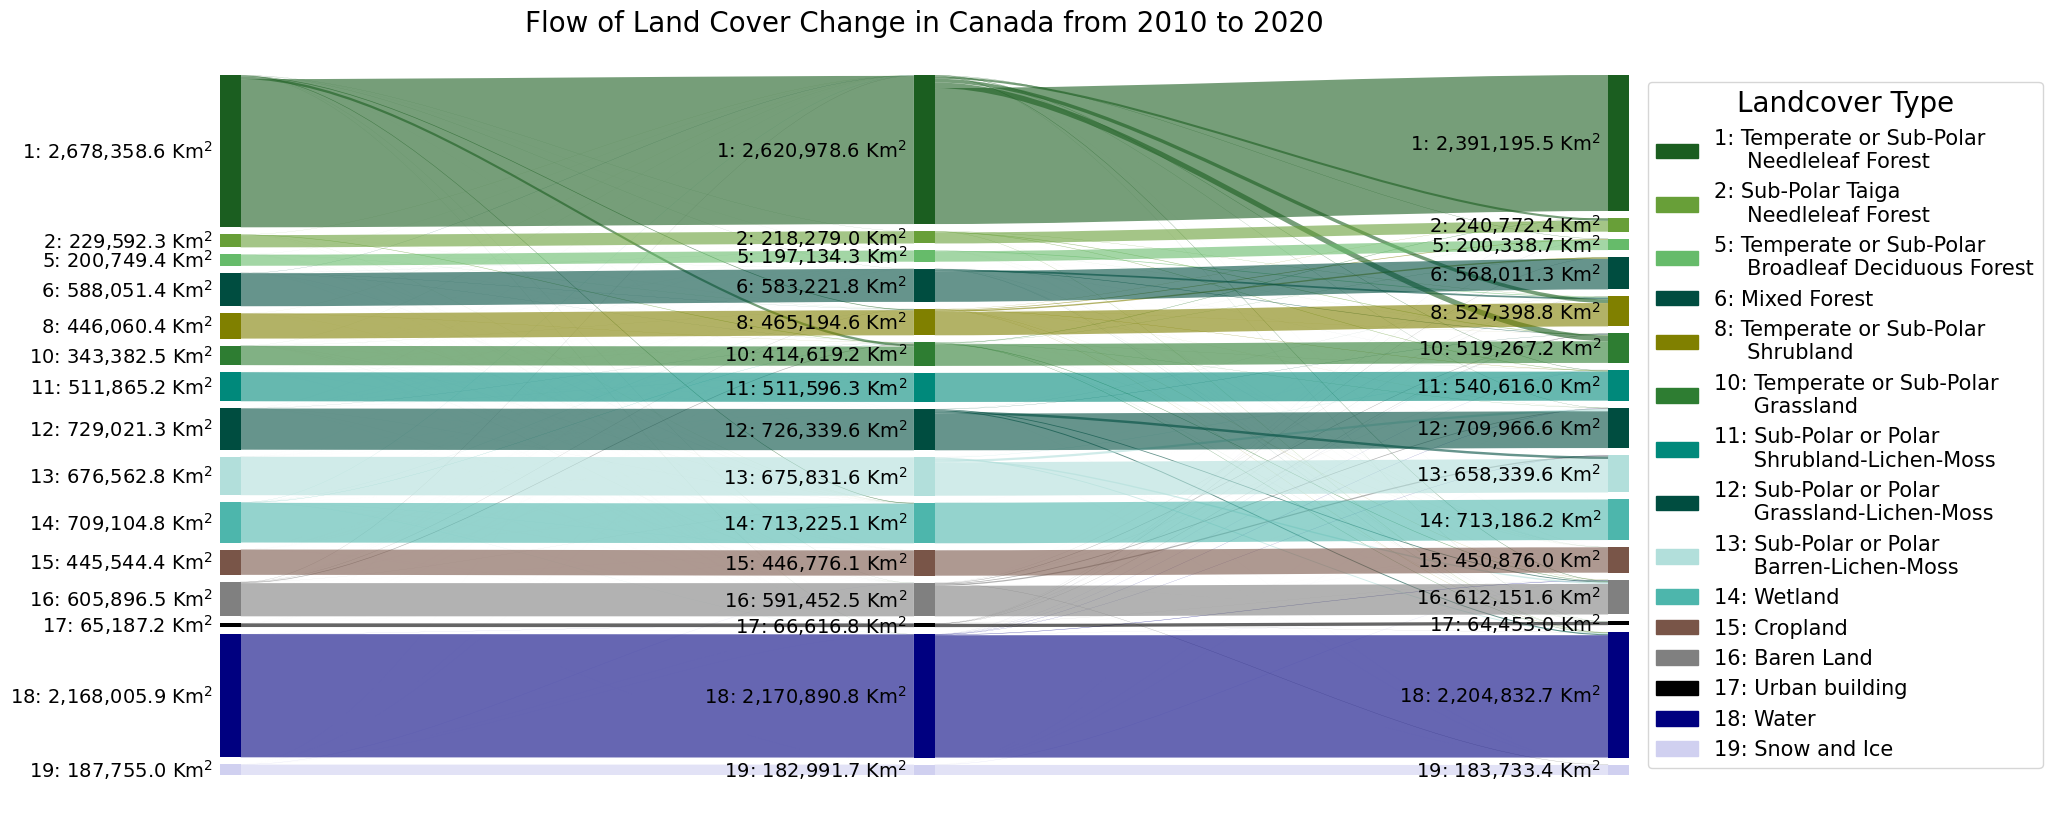

In [33]:
cmap = mcolors.ListedColormap(change_unique_color_list)

plt.figure(
    figsize = (20, 10)
)
sankey_change_only = Sankey(
    nodes = change_node_levels,
    node_opts=dict(label_format='{label}: {value:,.1f} Km$^2$'),
    flows = change_flows,
    flow_color_mode='source',
    cmap = cmap
)
sankey_change_only.draw()

plot_legend(
    legend_font_size = 15
)

plt.savefig(
    f"../assets/figures/landcover_canada_change_sankey_2010_2020.png", 
    transparent = True,
    bbox_inches = 'tight', # compress the content  
    pad_inches = 0, # have no extra margin
)

plt.title(
    "Flow of Land Cover Change in Canada from 2010 to 2020",
    fontsize = 20
)

plt.show()

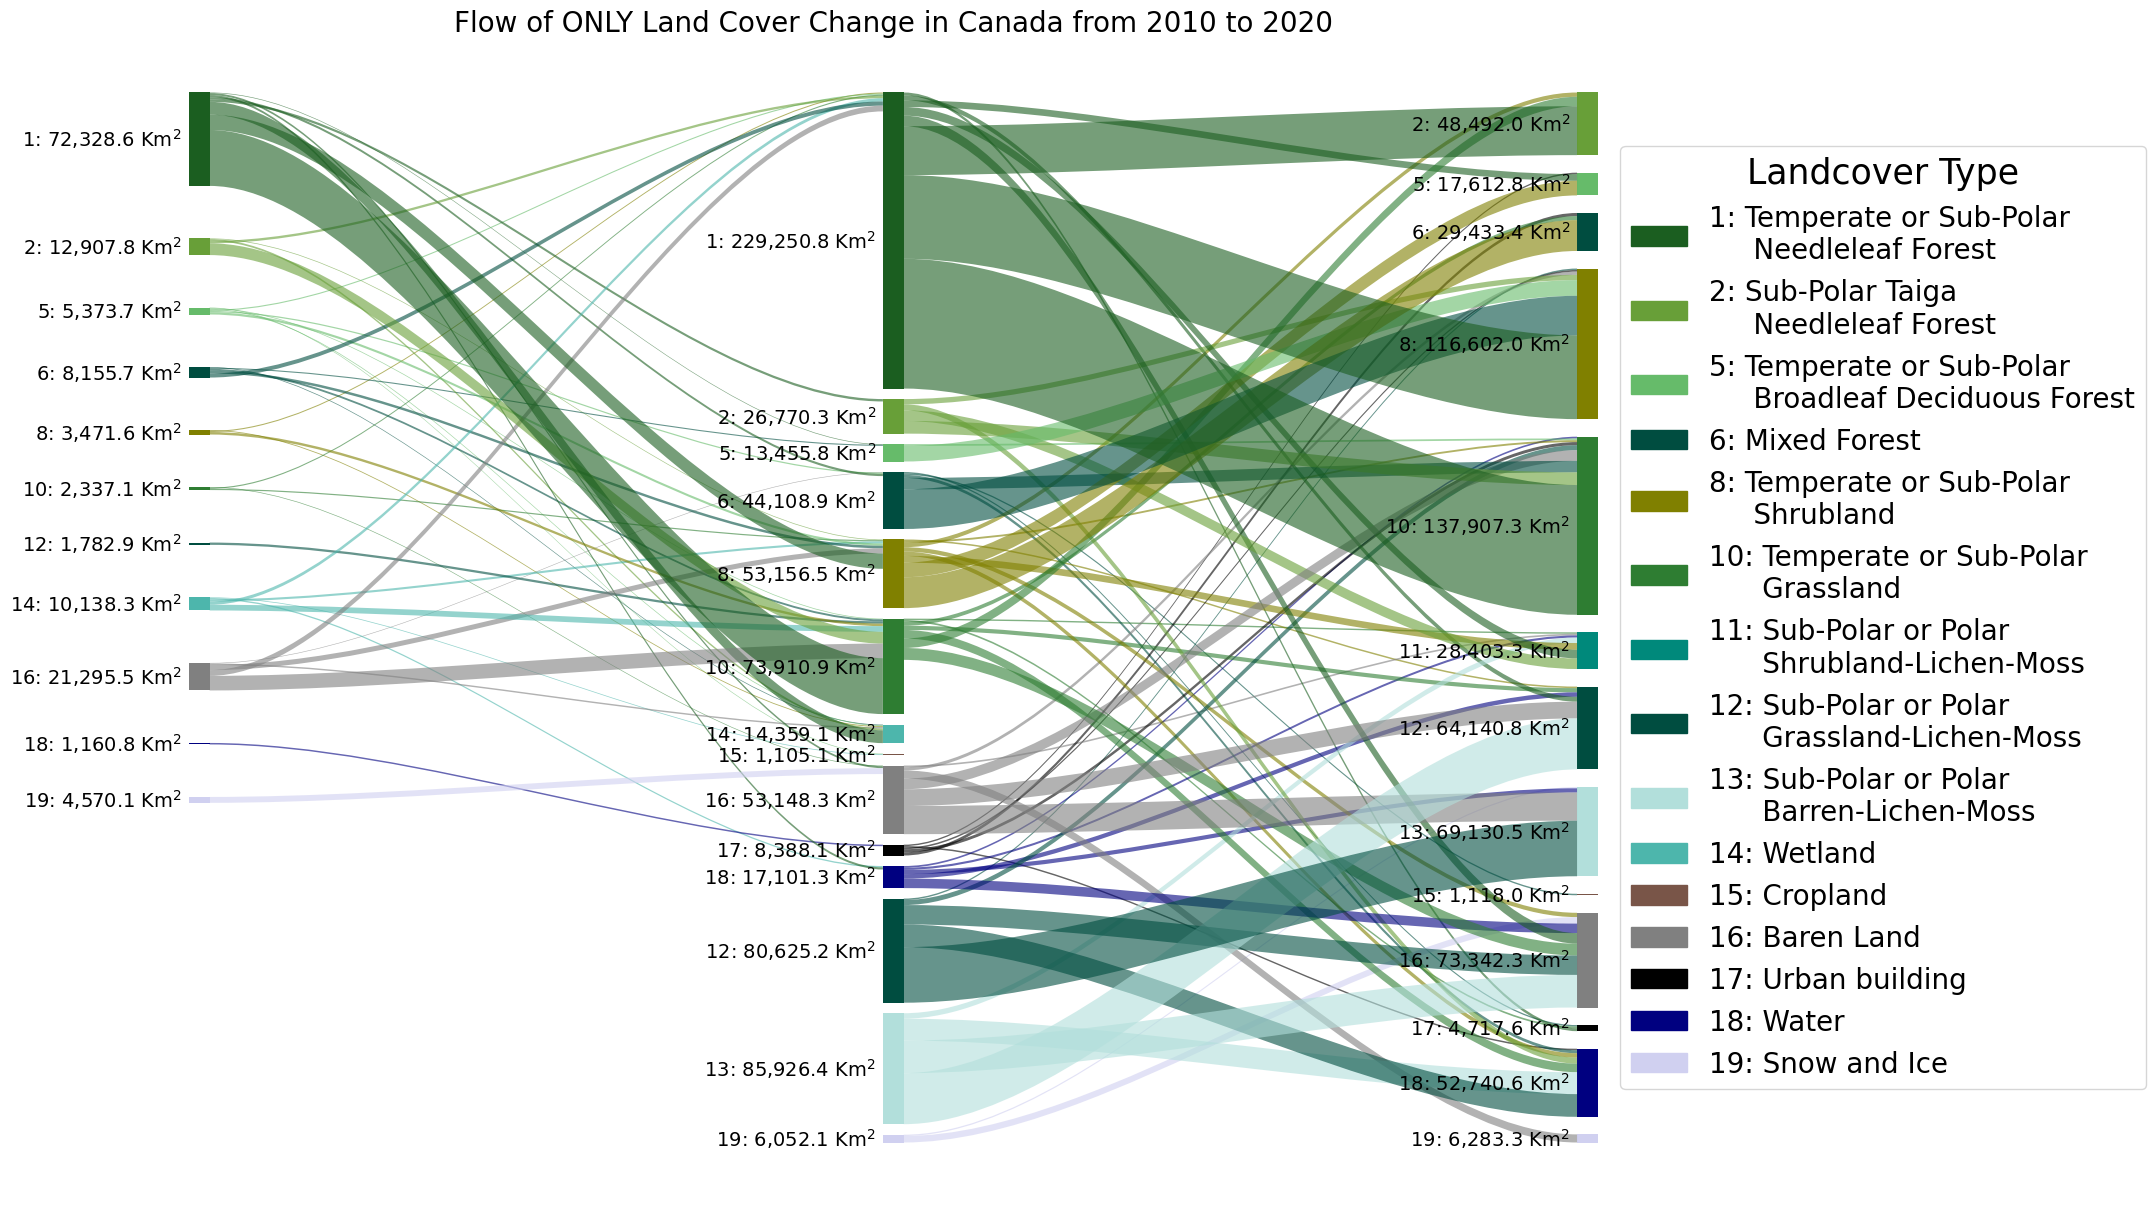

In [32]:
cmap = mcolors.ListedColormap(change_only_unique_color_list)

plt.figure(
    figsize = (20, 15)
)
sankey_change_only = Sankey(
    nodes = change_only_node_levels,
    node_opts=dict(label_format='{label}: {value:,.1f} Km$^2$'),
    flows = change_only_flows,
    flow_color_mode='source',
    cmap = cmap 
)
sankey_change_only.draw()

plot_legend()

plt.savefig(
    f"../assets/figures/landcover_canada_change_only_sankey_2010_2020.png", 
    transparent = True,
    bbox_inches = 'tight', # compress the content  
    pad_inches = 0, # have no extra margin
)

plt.title(
    "Flow of ONLY Land Cover Change in Canada from 2010 to 2020",
    fontsize = 20
)

plt.show()